# __Functional APIs in TensorFlow__


The functional APIs in TensorFlow is an alternative way to create and customize complex neural network models. It allows you to build models with more flexibility and handle multiple inputs and outputs.

- Connect layers as a graph
- Enables multiple inputs, multiple outputs, e.g. image and text, and non-linear architectures, e.g. residual connections
- Used in complex architectures, e.g. models with branches, such as Inception modules, and skip connections, such as ResNet
- Also used when you need to inspect or reuse intermediate layers

## Steps to be followed:
1. Import the required libraries
2. Load the dataset
3. Inspect the dataset and visualizing samples
4. Build the model
5. Compile the model
6. Evaluate the model


### Step 1: Import the required libraries


- Import necessary modules and classes from TensorFlow and other libraries, such as the Functional API components, data preprocessing tools, and visualization utilities.

- Set up the basic structure of a neural network model using the Functional API. It defines the input layer, followed by several hidden layers with specific activation functions and dropout regularization. It also specifies the output layer and the optimizer for model training.

- Include additional imports and utilities for data handling, such as splitting data into training and testing sets, calculating performance metrics like the confusion matrix, and visualizing images and results. These are useful for data preprocessing, model evaluation, and result visualization.

In [1]:
#!pip install tensorflow==2.17.0 scikeras==0.13.0 keras==3.2.0

In [2]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
# Import necessary modules and classes from TensorFlow and other libraries
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import itertools
import random

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

2025-09-05 20:53:39.303875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-05 20:53:39.324659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-05 20:53:39.330489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 20:53:39.348810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-05 20:53:40.391264: W ten

In [4]:
print("TensorFlow:", tf.__version__)
try:
    import keras
    print("Keras:", keras.__version__)
except Exception:
    pass


TensorFlow: 2.17.0
Keras: 3.2.0


### Step 2: Load the dataset
- Load the MNIST dataset, which contains handwritten digit images and their labels.
- The dataset is divided into training and testing sets, represented by variables **(x_train, y_train)** and **(x_test, y_test)**, respectively.
- We'll normalize later, when building the model graph.

In [5]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


### Step 3: Inspect the dataset and visualize the samples
- Import the MNIST dataset from the TensorFlow Keras library.
- The dimensions of the training and testing data arrays are printed using the shape attribute to show the number of samples and their respective dimensions.
- A loop is used to display the first nine images from the training set using Matplotlib.
- Each image is shown in a subplot, with the **cmap** parameter set to **gray** to display the images in grayscale.

Train: x=(60000, 28, 28), y=(60000,)
Test: x=(10000, 28, 28), y=(10000,)


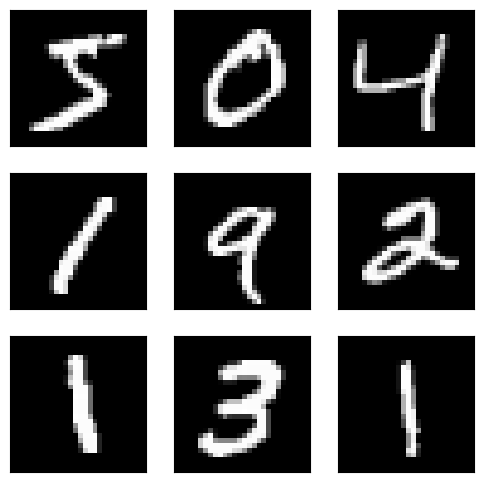

In [6]:
# Print the shape of the training and testing data
print('Train: x=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: x=%s, y=%s' % (x_test.shape, y_test.shape))

# Display the first nine images from the training set
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

  **Observations:**
  - The output **Train: x=(60000, 28, 28), y=(60000,)** indicates that the training dataset consists of 60,000 samples with dimensions of 28x28 pixels. The input images are grayscale, meaning they have only one color channel.
  - The output **Test: x=(10000, 28, 28), y=(10000,)** indicates that the testing dataset contains 10,000 samples with the same dimensions as the training dataset.
  - The **x** values represent the input images, and their shape is the number of samples, height, width. The **y** values represent the corresponding labels for the images, indicating the correct digit or class associated with each image.

### Step 4: Build the model
- The model consists of an input layer, a flatten layer, a dense layer with ReLU activation, and an output layer with softMax activation.
- The model is then returned. Calling **model.summary()** will display a summary of the model's architecture, including the shapes of the input and output tensors and the number of parameters in each layer.

In [7]:
# Function to build the neural network model using the Functional API to build the MLP with normalization
def build_model_with_functional():
    inputs = tf.keras.Input(shape=(28, 28), name="images")
    x = tf.keras.layers.Rescaling(1/255.0, name="rescale")(inputs)         # normalization inside the model
    x = tf.keras.layers.Flatten(name="flatten")(x)
    x = tf.keras.layers.Dense(256, activation="relu", name="dense_1")(x)
    x = tf.keras.layers.Dropout(0.3, name="dropout")(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax", name="logits")(x)
    return tf.keras.Model(inputs, outputs, name="mnist_mlp")


**Functional API Model Observations:**

- This model architecture consists of an input layer, a rescale (normalization) layer, a flatten layer, a dense layer with ReLU activation, a dropout layer,  and an output layer with softmax activation.
- The flatten layer is used to transform the 2D input images into a 1D array, while the dense layer performs the actual computations and transformations.
- The model has a total of **200,530** trainable parameters, which are learned during the training process. These parameters include the weights and biases of the dense layers.

In [8]:
# A small branched CNN to demonstrate multi-path topologies
def build_model_with_branch():
    inputs = Input(shape=(28, 28), name="images")
    x = Rescaling(1/255.0, name="rescale")(inputs)
    x = tf.keras.layers.Reshape((28, 28, 1))(x)

    p1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", name="p1_conv")(x)
    p2 = tf.keras.layers.MaxPooling2D(name="p2_pool")(x)
    p2 = tf.keras.layers.Conv2D(32, 1, activation="relu", name="p2_conv")(p2)

    x = tf.keras.layers.Concatenate(name="concat")([p1, p2])
    x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)
    outputs = Dense(10, activation="softmax", name="logits")(x)
    return Model(inputs, outputs, name="mnist_branchy_cnn")


**Branched CNN Observations**
- This model architecture consists of an input layer, a rescale (normalization) layer, a flatten layer, two convolutional layers with ReLU activation, a max pooling layer, a concatenation layer, an average pooling layer, and an output layer with softmax activation.
- The flatten layer is used to transform the 2D input images into a 1D array, while the dense layer performs the actual computations and transformations.
- The convolutional layers act like a magnifying glass, sliding small filters across the image, learning local patterns like edges, corners, and strokes in place.
- The pooling layers keep the signal learned from earlier layers
- The concatenate layer is the super power of the Functional API. It enables merging information from multiple paths, like stacking them along a chosen axis.
- The model has a total of **n** trainable parameters, which are learned during the training process. These parameters include the weights and biases of the dense layers.

In [9]:
# Choose which model to build:
model = build_model_with_functional()
# model = build_model_with_branch()  # uncomment to try the branched version


# Display the model architecture
model.summary()

I0000 00:00:1757123622.843290   26687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123622.887224   26687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123622.887277   26687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123622.890923   26687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123622.890966   26687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ images (InputLayer)             │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,530 (795.04 KB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Compile the model
- Compile the model using the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the metric.
- Use callbacks as training helpers; hooks that add monitoring, safety, and smart automation.
- The model is then trained with the callbacks using the training data **x_train** and labels **y_train**, aiming to minimize the loss and improve accuracy.

Epoch 1/20


I0000 00:00:1757123624.296424   26788 service.cc:146] XLA service 0x7f0a7c0035c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757123624.296572   26788 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-09-05 20:53:44.317817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-05 20:53:44.415587: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-09-05 20:53:45.721019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 48 bytes spill stores, 48 bytes spill loads

2025-09-05 20:53:45.759983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory

844/844 - 11s - 12ms/step - accuracy: 0.9068 - loss: 0.3186 - val_accuracy: 0.9658 - val_loss: 0.1231
Epoch 2/20
844/844 - 1s - 1ms/step - accuracy: 0.9554 - loss: 0.1494 - val_accuracy: 0.9743 - val_loss: 0.0903
Epoch 3/20
844/844 - 1s - 1ms/step - accuracy: 0.9679 - loss: 0.1092 - val_accuracy: 0.9783 - val_loss: 0.0778
Epoch 4/20
844/844 - 1s - 2ms/step - accuracy: 0.9729 - loss: 0.0866 - val_accuracy: 0.9790 - val_loss: 0.0731
Epoch 5/20
844/844 - 1s - 2ms/step - accuracy: 0.9774 - loss: 0.0721 - val_accuracy: 0.9798 - val_loss: 0.0687
Epoch 6/20
844/844 - 1s - 2ms/step - accuracy: 0.9808 - loss: 0.0620 - val_accuracy: 0.9802 - val_loss: 0.0676
Epoch 7/20
844/844 - 1s - 2ms/step - accuracy: 0.9828 - loss: 0.0539 - val_accuracy: 0.9820 - val_loss: 0.0634
Epoch 8/20
844/844 - 1s - 2ms/step - accuracy: 0.9851 - loss: 0.0465 - val_accuracy: 0.9805 - val_loss: 0.0651
Epoch 9/20
844/844 - 1s - 2ms/step - accuracy: 0.9866 - loss: 0.0417 - val_accuracy: 0.9842 - val_loss: 0.0589
Epoch 10/2

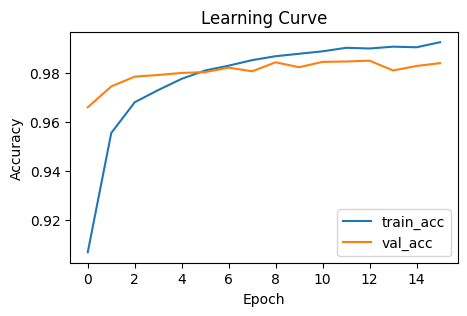

In [10]:
# Compile the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Initialize early stopping callback to monitor validation accuracy
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks,
                    verbose=2)

# quick learning-curve glance
plt.figure(figsize=(5,3))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Learning Curve")
plt.show()

**Observations:**
- The training output shows the progress of the model's training over consecutive epochs, with each epoch representing a complete pass through the training dataset.
- The output includes the values of the loss and accuracy metrics for each epoch, indicating how well the model is learning from the training data.
- The displayed metrics gradually improve as the model trains, with the loss decreasing and the accuracy increasing.
- The learning curve tells us where the model is underfitting, well-fit, or overfitting.

### Step 6: Evaluate the model
- The **model.evaluate(x_test, y_test)** is used to evaluate the trained model on the test dataset.
- It computes the loss value and metrics (such as accuracy) of the model's performance on the test data.

In [11]:
# Evaluate the trained model on the test dataset
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2025-09-05 20:54:14.770777: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 48 bytes spill stores, 48 bytes spill loads

2025-09-05 20:54:14.935991: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 148 bytes spill stores, 148 bytes spill loads



270/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9801 - loss: 0.0724

2025-09-05 20:54:16.370971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 16 bytes spill stores, 16 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9805 - loss: 0.0707
Test Loss: 0.061788409948349
Test Accuracy: 0.9830999970436096


**Observations:**

- The first number, **Test Loss**, represents the average loss or error of the model's predictions compared to the actual results on the test data. A lower value indicates better performance.
- The second number, **Test Accuracy**, represents the accuracy of the model based on the test data. It shows the proportion of correctly predicted results out of all the test samples. A higher value indicates better performance.

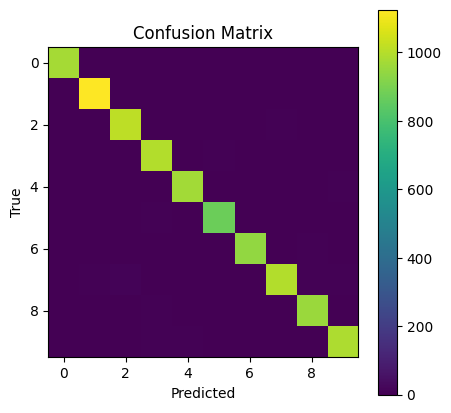

In [12]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()

***Observations**
- The bright diagonal means the model is consistently correctly classifying most digits.
- Each digit appears roughly equally frequent. No bias or imbalance shown.


### Step 6: Extract intermediate embeddings and visualize (PCA & t-SNE)

This cell shows how to:
1) Build a model that outputs the activations of an intermediate layer (`dense_1`).  
2) Compute embeddings for a subset of test images.  
3) Visualize them in 2D using PCA and t-SNE.


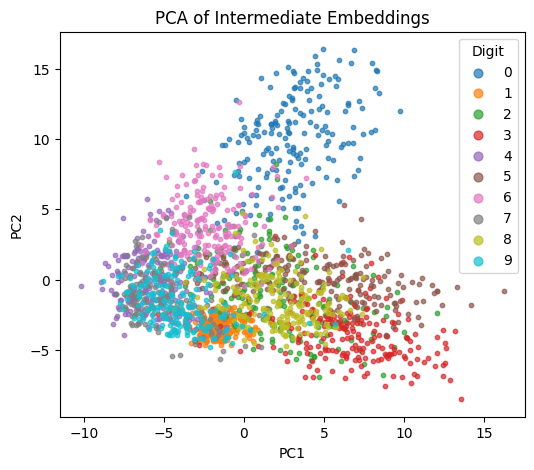

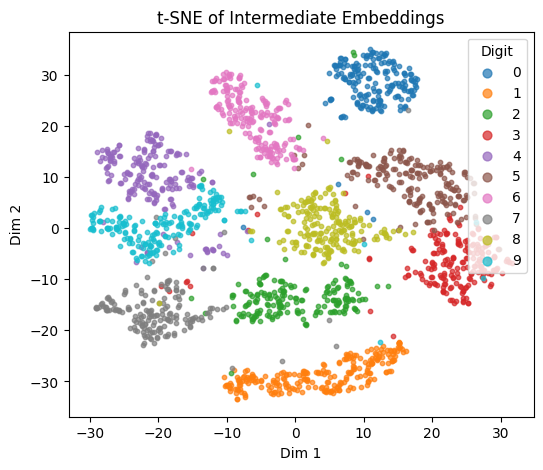

In [13]:

# Intermediate embeddings via Functional API 
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ensure the layer exists (use the name from the model.summary())
layer_name = "dense_1"
intermediate_layer = model.get_layer(layer_name)
embedding_model = tf.keras.Model(inputs=model.input, outputs=intermediate_layer.output)

# Subsample for speed
rng = np.random.default_rng(seed=42)
n_samples = min(2000, len(x_test))
idx = rng.choice(len(x_test), size=n_samples, replace=False)
x_sub = x_test[idx]
y_sub = y_test[idx]

# Compute embeddings (shape: [n_samples, embedding_dim])
embeddings = embedding_model.predict(x_sub, verbose=0)

# --- PCA to 2D ---
pca = PCA(n_components=2, random_state=42)
emb_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(6,5))
for digit in np.unique(y_sub):
    mask = (y_sub == digit)
    plt.scatter(emb_pca[mask, 0], emb_pca[mask, 1], s=10, label=str(digit), alpha=0.7)
plt.title("PCA of Intermediate Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(title="Digit", markerscale=2)
plt.show()

# --- t-SNE to 2D (slower; uses PCA init for speed/stability) ---
# Recall that t-SNE is stochastic neighbor embedding
tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
            perplexity=30, max_iter=500, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(6,5))
for digit in np.unique(y_sub):
    mask = (y_sub == digit)
    plt.scatter(emb_tsne[mask, 0], emb_tsne[mask, 1], s=10, label=str(digit), alpha=0.7)
plt.title("t-SNE of Intermediate Embeddings")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.legend(title="Digit", markerscale=2)
plt.show()

# Tip: Try different layers by changing `layer_name`, or different model variants (e.g., the branched CNN).


### PCA vs. t-SNE: What the plots show

- **PCA (top plot)**  
  - Linear projection → maximizes variance.  
  - Clusters are visible but overlap (e.g. 3, 5, 8).  
  - Good for fast inspection, but limited in separating nonlinear structure.  

- **t-SNE (bottom plot)**  
  - Nonlinear, neighborhood-preserving method.  
  - Digits form tight, well-separated clusters.  
  - Reveals that hidden layer embeddings encode clear digit groupings.  

**Takeaway:**  
PCA gives a rough, linear view, while t-SNE highlights the natural clusters.  
Together they show that the intermediate dense layer has learned a **meaningful digit representation space**.
